# Data Extraction, Transformation, Loading (ETL) with an example data set

This notebook shows the import of data and the transformation of columns. Also, some information extractions are shown like mean and standard deviation.

First, import necessary libraries for loading (pandas), data transformation (numpy, pandas) and visualization (seaborn, pyplot) and information extraction (pandas, statsmodel)

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import io
import requests

%matplotlib inline

pd.options.display.html.table_schema = True

### Import of the data sets (from Data Intelligence Hub)

The data sets can be found here: https://portal.dih.telekom.net/protected/marketplace/offer/21462ed0-5819-482c-bfcf-45f39a4adec6 or by searching the Marketplace for the offer’s title “Luftmesswerte für Stickoxide - Zeitreihen der städtischen Messstellen” or simply with the keyword “Luftmesswerte”. 

For simplification reasons in the following cell the data sets are directly downloaded from the open data portal Duesseldorf.

In [21]:
crib = "https://opendata.duesseldorf.de/sites/default/files/NO2_Stickstoffdioxid_Stundenwerte_{}.csv"

importedData = None
for year in [2015, 2016, 2017]:
    response = requests.get(crib.format(year))
    df = pd.read_csv(io.StringIO(response.text), sep = ";")
    if importedData is None:
        importedData = df
    else:
        importedData = importedData.append(df)

importedData.head(10)

,DATUM,Uhrzeit,Doro,Brinck
0,01.01.2015,1:00,"98,6","36,4"
1,01.01.2015,2:00,"52,2","33,5"
2,01.01.2015,3:00,"46,6","26,3"
3,01.01.2015,4:00,"48,5","27,6"
4,01.01.2015,5:00,"48,6","31,6"
5,01.01.2015,6:00,"50,1","34,8"
6,01.01.2015,7:00,"49,0","37,2"
7,01.01.2015,8:00,"49,3","36,8"
8,01.01.2015,9:00,"51,6","36,3"
9,01.01.2015,10:00,"46,2","35,6"


The values of the stations “Doro” and “Brinck” need to be transformed in order to work with them. The German floating point comma is replaced with a dot and the values are transformed into floats instead of objects.

In [22]:
for col in ['Doro','Brinck']:
    importedData[col] = importedData[col].str.replace(',', '.').astype(float)
importedData.head(3)

,DATUM,Uhrzeit,Doro,Brinck
0,01.01.2015,1:00,98.6,36.4
1,01.01.2015,2:00,52.2,33.5
2,01.01.2015,3:00,46.6,26.3


### Getting information about the data

Get the amount of NaNs and an overview about the range, means, deviations etc. 

In [23]:
importedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26304 entries, 0 to 8759
Data columns (total 4 columns):
DATUM      26304 non-null object
Uhrzeit    26304 non-null object
Doro       24683 non-null float64
Brinck     26011 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.0+ MB


In [24]:
importedData.describe()

,Doro,Brinck
count,24683.000000,26011.000000
mean,45.743443,27.748472
std,22.242339,16.722612
min,2.900000,1.900000
25%,28.700000,14.500000
50%,43.100000,25.400000
75%,59.900000,38.650000
max,275.300000,115.700000


### Datetime Index

For better visualizations the columns “DATUM” and “Uhrzeit” are concatenated and transformed into a datetime index.

In [25]:
importedData.index = pd.DatetimeIndex(pd.to_datetime(importedData['DATUM'] + ' ' + importedData['Uhrzeit']), name='Date')
importedData = importedData.drop(labels = ['DATUM','Uhrzeit'], axis = 1)
importedData.head(3)

,Doro,Brinck
Date,,
2015-01-01 01:00:00,98.6,36.4
2015-01-01 02:00:00,52.2,33.5
2015-01-01 03:00:00,46.6,26.3


### Visualizations

Below are some visualizations of the data sets. First the distributions of each dataset and the concatenated data sets (the three years in a row) are shown. Afterwards a linechart of the values and a decomposition of the timeseries can be seen in order to extract some information.

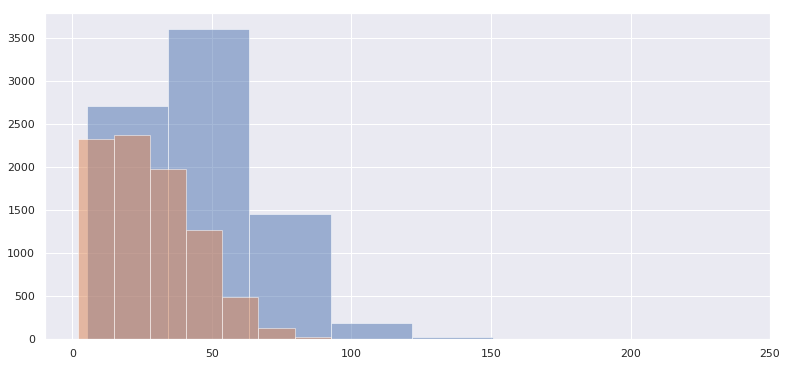

In [26]:
sns.set(rc={'figure.figsize':(13,6)})

importedData.loc[importedData.index.year == 2015].Doro.hist(bins=8, alpha=0.5)
importedData.loc[importedData.index.year == 2015].Brinck.hist(bins=8, alpha=0.5)

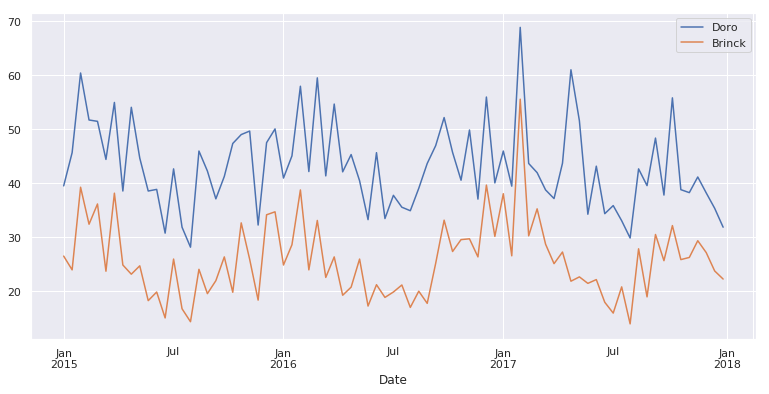

In [27]:
importedData.resample('2w').median().plot()

In the next graphs the seasonality of the NO2 values can be seen pretty clearly. During winter they are generally higher than during the summer months. Also, a slight trend downwards in 2017 can be seen.

/home/chris/.pyenv/versions/3.6.5/envs/work/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


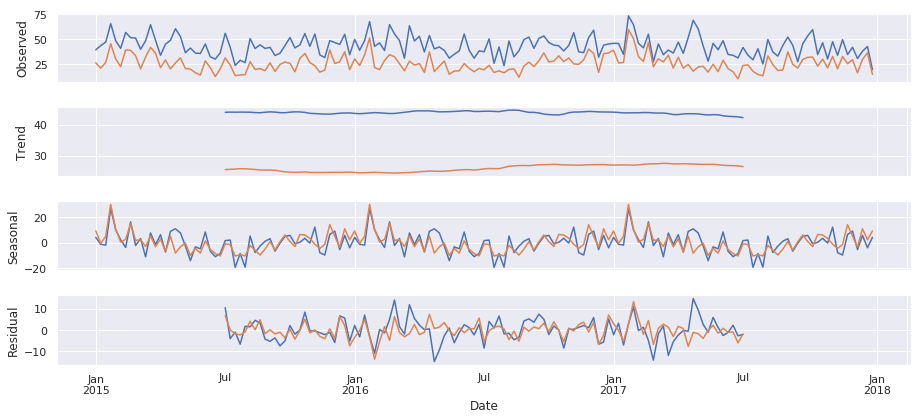

In [28]:
result = seasonal_decompose(importedData.resample('1W').median(), model='additive')
result.plot()
plt.show()

/home/chris/.pyenv/versions/3.6.5/envs/work/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


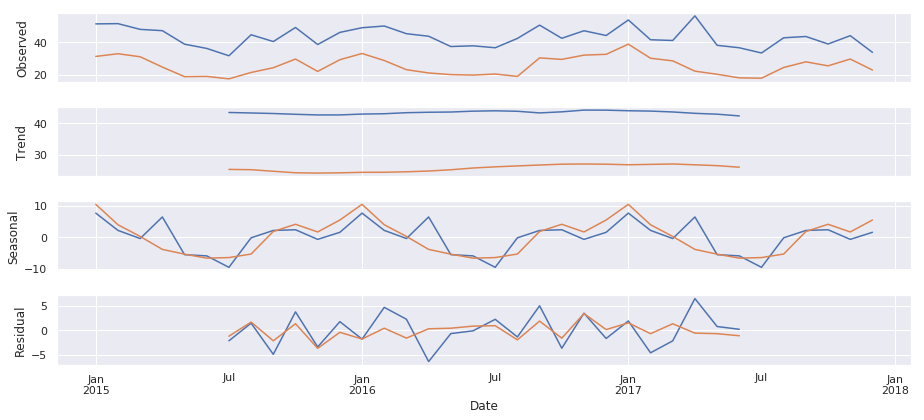

In [29]:
result = seasonal_decompose(importedData.resample('1M').median(), model='additive')
result.plot()
plt.show()

/home/chris/.pyenv/versions/3.6.5/envs/work/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


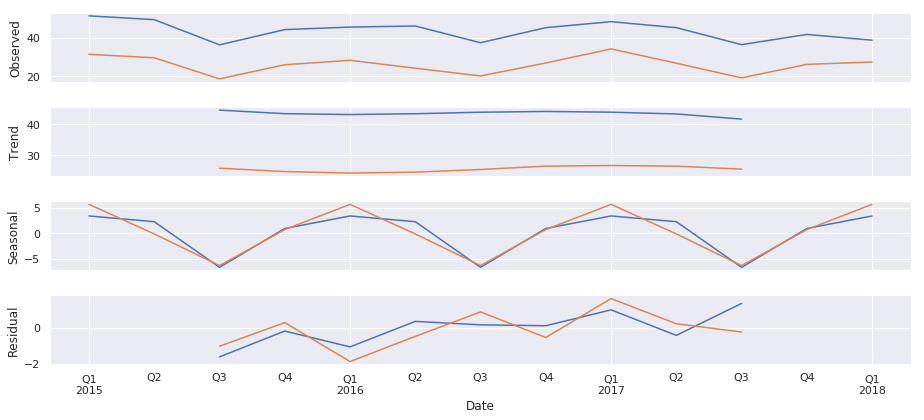

In [30]:
result = seasonal_decompose(importedData.resample('3M').median(), model='additive')
result.plot()
plt.show()